In [ ]:
import pandas as pd # 데이터 전처리
import numpy as np # 데이터 전처리
import random #데이터 전처리
from pandas import DataFrame #데이터 전처리
from collections import Counter #데이터 전처리

from tqdm import tqdm #시간 측정용

from sklearn.feature_extraction.text import CountVectorizer # model setting
from sklearn.model_selection import train_test_split  # model setting

from sklearn.naive_bayes import MultinomialNB  # model 관련
from sklearn.metrics import roc_auc_score  # model 성능 확인

import joblib
import re
from tqdm import tqdm_notebook
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import joblib

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd gdrive/My\ Drive/kb_data

/content/gdrive/My Drive/kb_data


# LSTM Classification

In [ ]:
prepared_train = pd.read_csv('prepared_train.csv', encoding='utf-8')

In [ ]:
del prepared_train['Unnamed: 0']

In [ ]:
prepared_train = pd.read_csv('prepared_train.csv', encoding='utf-8')

In [ ]:
#X_train = prepared_train.drop(['year_month', 'text', 'morph', 'orgin', 'smishing'], axis='columns')
X_origin = prepared_train['text']
Y_label = prepared_train['smishing']

In [ ]:
#train - test 분류
# 인덱싱 문제로 순서대로 train / test split
%%time
X_train, X_test, Y_train, Y_test = train_test_split(X_origin,
                                                    Y_label,
                                                    test_size = 0.2,
                                                    shuffle = False)
                                                    # random_state = 1825)

CPU times: user 32.4 ms, sys: 0 ns, total: 32.4 ms
Wall time: 32.4 ms


## tokenizer

In [ ]:
%%time
from keras.preprocessing.text import Tokenizer

# tokenizer
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

print("문자의 최대 길이 :" , max(len(l) for l in X_train))
print("문자의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [ ]:
print("문자의 최대 길이 : ", max(len(l) for l in X_test))
print("문자의 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

## max_len 기준에 따라 맞추기 (max_len = 264)

In [ ]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [ ]:
%%time
max_len = 264

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## label_data onehotencoding
- smishing: 0 1
- normal : 1 0 

In [ ]:
YY_train = pd.DataFrame(Y_train)
YY_train['smishing0'] = 1

for idx in YY_train.index:
    if YY_train['smishing'][idx] == 1:
        YY_train['smishing0'][idx] = 0
YY_train.head()


,smishing,smishing0
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [ ]:
YY_train = YY_train[['smishing0', 'smishing']]

In [ ]:
YY_train.head()

,smishing0,smishing
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


## lstm modeling

In [ ]:
%%time
# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

lucky_seed=[1996]


# enumerate: 인덱스와 값을 둘다 반복시킬 때 사용
for num,rs in tqdm(enumerate(lucky_seed)):

    kfold = KFold(n_splits=4, random_state = rs, shuffle = True)

    # numpy.zeros((row,col))
    # row*col size 영행렬 생성
    # train.shape[0],198 -> trainset 41400개, target값:198개
    cv=np.zeros((len(X_train),2))

    for n, (train_idx, validation_idx) in tqdm(enumerate(kfold.split(X_train))):
        
        x_train, x_validation = X_train[train_idx], X_train[validation_idx]
        y_train, y_validation = YY_train.loc[train_idx], YY_train.loc[validation_idx]
        
        lstm_model = Sequential()
        lstm_model.add(Embedding(max_words, 100))
        
        lstm_model.add(LSTM(128))
        lstm_model.add(Dense(2, activation='sigmoid'))
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        try:
            lstm_history = lstm_model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

            fig, loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()

            loss_ax.plot(lstm_history.history['loss'], 'y', label='train loss')
            loss_ax.plot(lstm_history.history['val_loss'], 'r', label='val loss')
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            loss_ax.legend(loc='upper left')

            acc_ax.plot(lstm_history.history['acc'], 'b', label='train acc')
            acc_ax.plot(lstm_history.history['val_acc'], 'g', label='val acc')
            acc_ax.set_ylabel('accuracy')
            acc_ax.legend(loc='upper left')

            plt.show()
        except:
            print('cant express')

        lstm_model.save("lstm_models/%s_%s_lstm_model.h5"%(n, rs))
        # 모델결과 저장 lib
        try:
            joblib.dump(lstm_model, 'lstm_models2/%s_fold_model_%s.pkl'%(n,rs))
        except:
            pass
        # numpy.zeros((row,col))로 만들어주었던 영행렬: cv
        # data object에 X_validation 예측 값을 넣어줌
        # CROSS-VALIDATION , EVALUATE CV
        try: 
            cv[validation_idx,:] = lstm_model.predict(x_validation)
        except:
            pass

0it [00:00, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 3991s 25ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0037 - val_accuracy: 0.9989
Epoch 2/2
159810/159810 [==============================] - 4039s 25ms/step - loss: 9.6415e-04 - accuracy: 0.9998 - val_loss: 0.0066 - val_accuracy: 0.9992
cant express



1it [2:15:29, 8129.54s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 4165s 26ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 2/2
159810/159810 [==============================] - 4098s 26ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0018 - val_accuracy: 0.9996
cant express



2it [4:34:44, 8197.19s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 4109s 26ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0023 - val_accuracy: 0.9992
Epoch 2/2
159810/159810 [==============================] - 3991s 25ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy: 0.9992
cant express



3it [6:51:08, 8193.10s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 3596s 23ms/step - loss: 0.0076 - accuracy: 0.9983 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 2/2
159810/159810 [==============================] - 3466s 22ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0028 - val_accuracy: 0.9990
cant express



4it [8:50:05, 7951.40s/it]
1it [8:50:05, 31805.59s/it]
0it [00:00, ?it/s]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 3462s 22ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 2/2
 29920/159810 [====>.........................] - ETA: 47:02 - loss: 0.0011 - accuracy: 0.9998

0it [00:00, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2146s 13ms/step - loss: 0.0072 - accuracy: 0.9984 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 2/2
159810/159810 [==============================] - 2091s 13ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0016 - val_accuracy: 0.9993
cant express



1it [1:11:48, 4308.51s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2125s 13ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 2/2
159810/159810 [==============================] - 2156s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy: 0.9993
cant express



2it [2:24:11, 4318.87s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2130s 13ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0054 - val_accuracy: 0.9991
Epoch 2/2
159810/159810 [==============================] - 2120s 13ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0054 - val_accuracy: 0.9990
cant express



3it [3:36:03, 4316.91s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2107s 13ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0026 - val_accuracy: 0.9993
Epoch 2/2
159810/159810 [==============================] - 2115s 13ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0059 - val_accuracy: 0.9987
cant express



4it [4:47:28, 4312.07s/it]
1it [4:47:28, 17248.30s/it]


CPU times: user 6h 40min 55s, sys: 56min 38s, total: 7h 37min 33s
Wall time: 4h 47min 28s


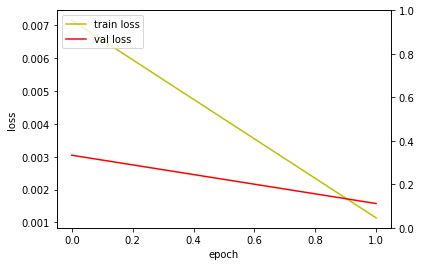

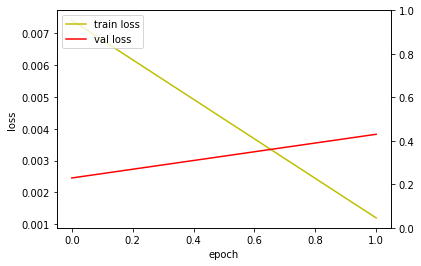

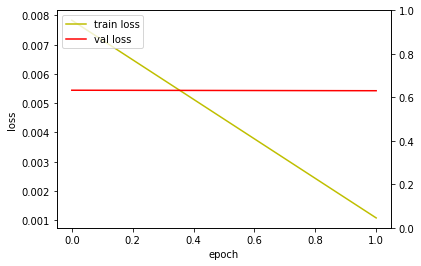

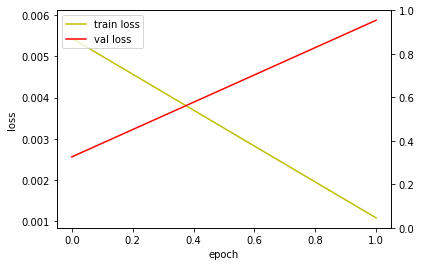

In [ ]:
%%time
# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

lucky_seed=[8]


# enumerate: 인덱스와 값을 둘다 반복시킬 때 사용
for num,rs in tqdm(enumerate(lucky_seed)):

    kfold = KFold(n_splits=4, random_state = rs, shuffle = True)

    # numpy.zeros((row,col))
    # row*col size 영행렬 생성
    # train.shape[0],198 -> trainset 41400개, target값:198개
    cv=np.zeros((len(X_train),2))

    for n, (train_idx, validation_idx) in tqdm(enumerate(kfold.split(X_train))):
        
        x_train, x_validation = X_train[train_idx], X_train[validation_idx]
        y_train, y_validation = YY_train.loc[train_idx], YY_train.loc[validation_idx]
        
        lstm_model = Sequential()
        lstm_model.add(Embedding(max_words, 100))
        
        lstm_model.add(LSTM(128))
        lstm_model.add(Dense(2, activation='sigmoid'))
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        try:
            lstm_history = lstm_model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

            fig, loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()

            loss_ax.plot(lstm_history.history['loss'], 'y', label='train loss')
            loss_ax.plot(lstm_history.history['val_loss'], 'r', label='val loss')
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            loss_ax.legend(loc='upper left')

            acc_ax.plot(lstm_history.history['acc'], 'b', label='train acc')
            acc_ax.plot(lstm_history.history['val_acc'], 'g', label='val acc')
            acc_ax.set_ylabel('accuracy')
            acc_ax.legend(loc='upper left')

            plt.show()
        except:
            print('cant express')

        lstm_model.save("lstm_models/%s_%s_lstm_model.h5"%(n, rs))
        # 모델결과 저장 lib
        try:
            joblib.dump(lstm_model, 'lstm_models2/%s_fold_model_%s.pkl'%(n,rs))
        except:
            pass
        # numpy.zeros((row,col))로 만들어주었던 영행렬: cv
        # data object에 X_validation 예측 값을 넣어줌
        # CROSS-VALIDATION , EVALUATE CV
        try: 
            cv[validation_idx,:] = lstm_model.predict(x_validation)
        except:
            pass

0it [00:00, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2137s 13ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 2/2
159810/159810 [==============================] - 2132s 13ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0019 - val_accuracy: 0.9994
cant express



1it [1:12:12, 4332.13s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2115s 13ms/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0027 - val_accuracy: 0.9989
Epoch 2/2
159810/159810 [==============================] - 2109s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 0.9989
cant express



2it [2:23:40, 4318.89s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2164s 14ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 2/2
159810/159810 [==============================] - 2149s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 0.9991
cant express



3it [3:36:36, 4336.12s/it]

Train on 159810 samples, validate on 17757 samples
Epoch 1/2
159810/159810 [==============================] - 2139s 13ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 2/2
159810/159810 [==============================] - 2123s 13ms/step - loss: 8.0716e-04 - accuracy: 0.9999 - val_loss: 0.0031 - val_accuracy: 0.9993
cant express



4it [4:48:40, 4330.13s/it]
1it [4:48:40, 17320.53s/it]


CPU times: user 6h 43min 42s, sys: 57min 2s, total: 7h 40min 45s
Wall time: 4h 48min 40s


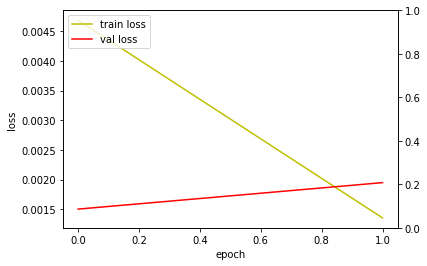

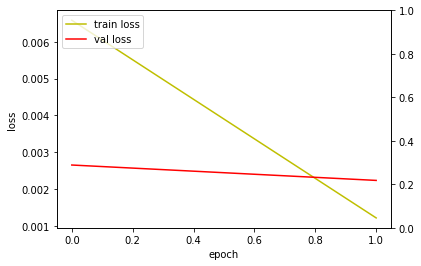

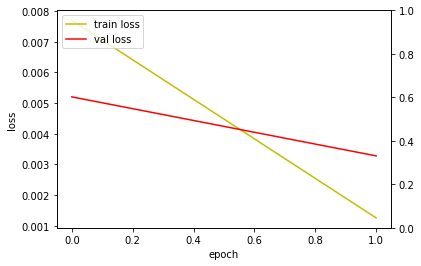

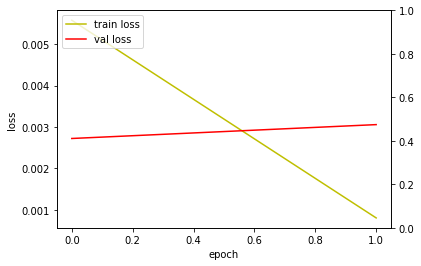

In [ ]:
%%time
# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

lucky_seed=[25]


# enumerate: 인덱스와 값을 둘다 반복시킬 때 사용
for num,rs in tqdm(enumerate(lucky_seed)):

    kfold = KFold(n_splits=4, random_state = rs, shuffle = True)

    # numpy.zeros((row,col))
    # row*col size 영행렬 생성
    # train.shape[0],198 -> trainset 41400개, target값:198개
    cv=np.zeros((len(X_train),2))

    for n, (train_idx, validation_idx) in tqdm(enumerate(kfold.split(X_train))):
        
        x_train, x_validation = X_train[train_idx], X_train[validation_idx]
        y_train, y_validation = YY_train.loc[train_idx], YY_train.loc[validation_idx]
        
        lstm_model = Sequential()
        lstm_model.add(Embedding(max_words, 100))
        
        lstm_model.add(LSTM(128))
        lstm_model.add(Dense(2, activation='sigmoid'))
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        try:
            lstm_history = lstm_model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

            fig, loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()

            loss_ax.plot(lstm_history.history['loss'], 'y', label='train loss')
            loss_ax.plot(lstm_history.history['val_loss'], 'r', label='val loss')
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            loss_ax.legend(loc='upper left')

            acc_ax.plot(lstm_history.history['acc'], 'b', label='train acc')
            acc_ax.plot(lstm_history.history['val_acc'], 'g', label='val acc')
            acc_ax.set_ylabel('accuracy')
            acc_ax.legend(loc='upper left')

            plt.show()
        except:
            print('cant express')

        lstm_model.save("lstm_models/%s_%s_lstm_model.h5"%(n, rs))
        # 모델결과 저장 lib
        try:
            joblib.dump(lstm_model, 'lstm_models2/%s_fold_model_%s.pkl'%(n,rs))
        except:
            pass
        # numpy.zeros((row,col))로 만들어주었던 영행렬: cv
        # data object에 X_validation 예측 값을 넣어줌
        # CROSS-VALIDATION , EVALUATE CV
        try: 
            cv[validation_idx,:] = lstm_model.predict(x_validation)
        except:
            pass

In [ ]:
from keras.models import load_model

In [ ]:
models = os.listdir('lstm_models/')
models_list = [x for x in models if x.endswith(".h5")]

In [ ]:
models_list

['0_1996_lstm_model.h5',
 '1_1996_lstm_model.h5',
 '2_1996_lstm_model.h5',
 '3_1996_lstm_model.h5',
 '0_8_lstm_model.h5',
 '1_8_lstm_model.h5',
 '2_8_lstm_model.h5',
 '3_8_lstm_model.h5',
 '0_25_lstm_model.h5',
 '1_25_lstm_model.h5',
 '2_25_lstm_model.h5',
 '3_25_lstm_model.h5']

## lstm prediction

In [ ]:
# MODEL LOAD & TEST PREDICT
# 12 MODELS 평균 사용
%%time
models = os.listdir('lstm_models/')
models_list = [x for x in models if x.endswith(".h5")]

# 모델결과가 잘 나왔는지 check
# assert: 좌항과 우항의 값이 같으면 정상 작동, 다르면 오류 발생
assert len(models_list) ==12


temp_predictions = np.zeros((X_test.shape[0],2))

# 12개 모델을 반복시켜서 결과산출 -> 12로 나눠서 평균값 계산
for model in tqdm(models_list):
    model = load_model('lstm_models/'+model)
    predict_proba = model.predict(X_test)
    temp_predictions += predict_proba/12

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
100%|██████████| 12/12 [12:55<00:00, 64.64s/it]

CPU times: user 12min 34s, sys: 2.33 s, total: 12min 36s
Wall time: 12min 55s


In [ ]:

submission = pd.DataFrame(data=np.zeros((X_test.shape[0],2)))
submission.index = Y_test.index 
submission.index.name = 'id'
submission+=temp_predictions

submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.set_index('id', inplace = True)

submission['pred'] = 0
for idx in submission.index:
    if submission['1'][idx] > submission['0'][idx]:
        submission['pred'][idx] = 1


submission.to_csv("lstm_submission/lstm_submission.csv")

## classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
result = classification_report(Y_test, submission['pred'], target_names=['normal','smishing'])

In [ ]:
print(result)

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     51205
    smishing       0.99      0.98      0.98      7984

    accuracy                           1.00     59189
   macro avg       0.99      0.99      0.99     59189
weighted avg       1.00      1.00      1.00     59189



# SVM, LGBM, LSTM False record 비교

## 1. SVM   - 속도:상  F-meause: 상
    - 속도: 상  
    - F-meausure: 상
    - false negative: 79개
    - false positive: 1개

In [ ]:
submissions_list= os.listdir('svm_models/submissions')

In [ ]:
# 모델마다 false record 탐색
neg_dict = dict()
for sub in submissions_list:
    try:
        df = pd.read_csv('svm_models/submissions/'+sub, engine='python')
        df.set_index('id', inplace= True)
        # 각 모델마다 false record를 담은 임시 리스트
        temp_list = list()
        for idx in df.index:
            if (df['pred'][idx] != Y_test[idx]):
                # 없을 때만 추가
                temp_list.append(idx)
        neg_dict[str(sub)] = temp_list
    except:
        pass
    


In [ ]:
# 30개 모델이 공통적으로 틀린 record 파악 share_neg = list()
temp_list = list()
share_neg = list()

for csv_list in neg_dict:
    for r in neg_dict[csv_list]:
        temp_list.append(r)

temp_list.sort()

# 틀린 record 중복 제거: total_list
total_list = set(temp_list)
# id_num = dict()
# key: record ID, value: 틀린 갯수 (0 ~ 30)
id_num = dict()
for i in total_list:
    num = temp_list.count(i)
    id_num[i] = num


In [ ]:
#over_list: 30개 모델 모두 틀린 record
over_list = list()
for i in id_num:
    if (id_num[i] == 30):
        over_list.append(i)
        

In [ ]:
false_pos_text = list()
false_neg_text = list()
false_pos_idx = list()
false_neg_idx = list()

for idx in over_list:
    # false negative: 실제로는 양성인데, 검사결과 음성
    if (prepared_train['smishing'][idx] == 1):
        false_neg_idx.append(idx)
        false_neg_text.append(prepared_train['orgin'][idx])
    # false positve: 실제로는 음성인데, 검사결과 양성
    elif (prepared_train['smishing'][idx] == 0):
        false_pos_idx.append(idx)
        false_pos_text.append(prepared_train['orgin'][idx])

In [ ]:
len(false_pos_idx)

1

In [ ]:
len(false_neg_idx)

79

In [ ]:
false_record_svm = false_pos_idx + false_neg_idx

## 2. LGBM  - 속도:중  F-meause: 중
    - 속도: 중
    - F-measure: 중

    - false negative: 196개
    - false positive: 6개

In [ ]:
submissions_list= os.listdir('lgbm_models/submissions')[:30]

In [ ]:
# 모델마다 false record 탐색
neg_dict = dict()
for sub in submissions_list:
    try:
        df = pd.read_csv('lgbm_models/submissions/'+sub, engine='python')
        df.set_index('id', inplace= True)
        # 각 모델마다 false record를 담은 임시 리스트
        temp_list = list()
        for idx in df.index:
            if (df['pred'][idx] != Y_test[idx]):
                # 없을 때만 추가
                temp_list.append(idx)
        neg_dict[str(sub)] = temp_list
    except:
        pass
    


In [ ]:
# 30개 모델이 공통적으로 틀린 record 파악 share_neg = list()
temp_list = list()
share_neg = list()

for csv_list in neg_dict:
    for r in neg_dict[csv_list]:
        temp_list.append(r)

temp_list.sort()

# 틀린 record 중복 제거: total_list
total_list = set(temp_list)
# id_num = dict()
# key: record ID, value: 틀린 갯수 (0 ~ 30)
id_num = dict()
for i in total_list:
    num = temp_list.count(i)
    id_num[i] = num


In [ ]:
#over_list: 30개 모델 틀린 record
over_list2 = list()
for i in id_num:
    if (id_num[i] == 30):
        over_list2.append(i)

In [ ]:
false_pos_text2 = list()
false_neg_text2 = list()
false_pos_idx2 = list()
false_neg_idx2 = list()

for idx in over_list2:
    # false negative: 실제로는 양성인데, 검사결과 음성
    if (prepared_train['smishing'][idx] == 1):
        false_neg_idx2.append(idx)
        false_neg_text2.append(prepared_train['orgin'][idx])
    # false positve: 실제로는 음성인데, 검사결과 양성
    elif (prepared_train['smishing'][idx] == 0):
        false_pos_idx2.append(idx)
        false_pos_text2.append(prepared_train['orgin'][idx])

In [ ]:
false_record_lgbm = false_pos_idx2 + false_neg_idx2

In [ ]:
len(false_pos_idx2)

6

In [ ]:
len(false_neg_idx2)

196

## 3. LSTM   - 속도:하  F-meause: 하
    - 속도: 중
    - F-meausre: 하

    - false negative: 166개
    - false positive: 117개
    - 참고: LSTM은 1번만 모델링함 (시간이 너무 오래 걸림)

In [ ]:
false_pos_text3 = list()
false_neg_text3 = list()
false_pos_idx3 = list()
false_neg_idx3 = list()

In [ ]:
for idx in submission.index:
    if (submission['pred'][idx] != Y_test[idx]):
        # false negative: 실제로는 양성인데, 검사결과 음성
        if Y_test[idx] == 1:
            false_neg_idx3.append(idx)
            false_neg_text3.append(prepared_train['orgin'][idx])
        # false positive: 실제로는 음성인데, 검사결과 양성
        elif Y_test[idx] == 0:
            false_pos_idx3.append(idx)
            false_pos_text3.append(prepared_train['orgin'][idx])

In [ ]:
false_record_lstm = false_pos_idx3 + false_neg_idx3

In [ ]:
len(false_record_lstm)

283

In [ ]:
len(false_pos_idx3)

117

In [ ]:
len(false_neg_idx3)

166

# 세 모델 모두 공통적으로 틀린 record: 37개


In [ ]:
three = list()

for i in false_record_svm:
    for k in false_record_lgbm:
        for j in false_record_lstm:
            if (i == k == j):
                three.append(i)

In [ ]:
len(three)

37

In [ ]:
print(three)

[256005, 287239, 257551, 292368, 275522, 255064, 259673, 282717, 275060, 287888, 258711, 293527, 257704, 259761, 260286, 283839, 255179, 280781, 258259, 259805, 250099, 255764, 258851, 270633, 257893, 259432, 289651, 258933, 253852, 258462, 257966, 257463, 260036, 258012, 256990, 242668, 255484]


# Main Model: SVM
- SVM의 false record를 보완해줄 수 있는 모델 선택 (LGBM or LSTM)

## SVM 틀린 record 예측 확률 EDA

## LGBM 틀린 record 예측 확률 EDA

## LSTM 틀린 record 예측 확률 EDA

In [ ]:
submission = pd.read_csv("lstm_submission/lstm_submission.csv")
submission.set_index('id', inplace = True)

In [ ]:
for lstm in false_record_lstm:
    print(lstm)
    print("실측 값: ", Y_test[lstm], "  예측 값: ", submission['pred'][lstm])
    print(submission['0'][lstm], submission['1'][lstm])
    print()

237337
실측 값:  0   예측 값:  1
0.22189368681210908 0.795226339250803

237789
실측 값:  0   예측 값:  1
0.24290498734245602 0.7811980992555618

238551
실측 값:  0   예측 값:  1
0.26813035809482244 0.7465920131653547

238552
실측 값:  0   예측 값:  1
0.27918280059566314 0.7370259705930948

239287
실측 값:  0   예측 값:  1
0.2254267011214779 0.7906258013099432

239969
실측 값:  0   예측 값:  1
0.2124096646507496 0.8036982081830502

240252
실측 값:  0   예측 값:  1
0.24933945988129835 0.7792294528335333

240359
실측 값:  0   예측 값:  1
0.2519690561430252 0.7732776589691639

240525
실측 값:  0   예측 값:  1
0.272091287348303 0.7490008622407913

240690
실측 값:  0   예측 값:  1
0.2932532761133189 0.7307644877582788

240748
실측 값:  0   예측 값:  1
0.3510671557787646 0.6629912490025163

241662
실측 값:  0   예측 값:  1
0.23309103876590603 0.7823681998997927

241780
실측 값:  0   예측 값:  1
0.2348906287737691 0.7902814932167529

242338
실측 값:  0   예측 값:  1
0.21659045436490487 0.803943058475852

242723
실측 값:  0   예측 값:  1
0.20935503489022267 0.8071782402694225

24274

## SVM과 LGBM 비교

In [ ]:
same_svmNlgbm = list()
for svm in false_record_svm:
    if svm in false_record_lgbm:
        same_svmNlgbm.append(svm)
print(len(same_svmNlgbm))
print(same_svmNlgbm) 

38
[256005, 287239, 257551, 292368, 275522, 255064, 259673, 282717, 275060, 287888, 258711, 293527, 257704, 259761, 260286, 283839, 255179, 280781, 258259, 259805, 250099, 255764, 258851, 270633, 257893, 259432, 289651, 258933, 253852, 258462, 257966, 243634, 257463, 260036, 258012, 256990, 242668, 255484]


In [ ]:
sub_lgbm = pd.read_csv('lgbm_models/submissions/[1024, 1363, 7234]_submission.csv')
sub_lgbm.set_index('id', inplace = True)

In [ ]:
for idx in false_record_svm:
    print(idx)
    print(sub_lgbm['pred'][idx], Y_test[idx])
    print(sub_lgbm['1'][idx])
    print()

253858
0 0
0.0063883176180836035

256005
0 1
0.09846394209970782

287239
0 1
2.843121847735089e-05

275982
1 1
0.6503752673931257

257551
0 1
0.14017756860545455

292368
0 1
0.0004048758537406773

283677
1 1
0.6503752673931257

271390
1 1
0.591399608102725

280609
1 1
0.5870267201938572

272932
1 1
0.6503752673931257

255546
1 1
0.9605806896037478

255040
1 1
0.9614511443995106

275522
0 1
0.0008452810902115753

284737
1 1
0.6247333131165007

255064
0 1
0.1414127596969916

259673
0 1
0.15179662071619615

282717
0 1
0.0002669197096708386

275557
1 1
0.591399608102725

275060
0 1
0.00971415967169568

287888
0 1
0.005362045294550554

258711
0 1
0.09096160115331133

293527
0 1
0.014465341844422068

285862
1 1
0.7499642805858012

257704
0 1
0.1414127596969916

259761
0 1
0.14017756860545455

260286
0 1
0.1414127596969916

283839
0 1
2.843121847735089e-05

255168
1 1
0.9365049974603531

255179
0 1
0.15179662071619615

280781
0 1
0.04014912082966575

258259
0 1
0.22199212160974746

259805
0 1

## SVM과 LSTM 비교

In [ ]:
same_svmNlstm = list()
for svm in false_record_svm:
    if svm in false_record_lstm:
        same_svmNlstm.append(svm)
print(len(same_svmNlstm))
print(same_svmNlstm) 

68
[256005, 287239, 275982, 257551, 292368, 283677, 280609, 272932, 255546, 255040, 275522, 255064, 259673, 282717, 275060, 287888, 258711, 293527, 257704, 259761, 260286, 283839, 255168, 255179, 280781, 258259, 259805, 266982, 260332, 260335, 250099, 256760, 288523, 255764, 257813, 258851, 270633, 259884, 256819, 262471, 256338, 258386, 259932, 290652, 257893, 259432, 289651, 258933, 255353, 259985, 255894, 260502, 253852, 258462, 257966, 267695, 261553, 257463, 260036, 261578, 258012, 256990, 242668, 279533, 257519, 270326, 288757, 255484]


In [ ]:
for idx in false_record_svm:
    print(idx)
    print(submission['pred'][idx], Y_test[idx])
    print(submission['1'][idx])
    print()

253858
0 0
0.04751574502006406

256005
0 1
0.12751855541137047

287239
0 1
0.0003459958442704192

275982
0 1
0.4791584815829992

257551
0 1
0.16257679188856855

292368
0 1
0.14024555403739214

283677
0 1
0.4791584815829992

271390
1 1
0.7879932057112455

280609
0 1
0.256732773326803

272932
0 1
0.4791584815829992

255546
0 1
0.0966418553616677

255040
0 1
0.04255677109176759

275522
0 1
0.013621581776533276

284737
1 1
0.7790665347129107

255064
0 1
0.2581474488833919

259673
0 1
0.0020863403693169857

282717
0 1
0.0007605529306147217

275557
1 1
0.7879932057112455

275060
0 1
0.005618746138111419

287888
0 1
0.00272763214798033

258711
0 1
0.006042165224698692

293527
0 1
0.19744905031984672

285862
1 1
0.8244236763566732

257704
0 1
0.2581474488833919

259761
0 1
0.093302925262833

260286
0 1
0.10925190360285343

283839
0 1
0.0003459958442704192

255168
0 1
0.04255677109176759

255179
0 1
0.0019479637471420121

280781
0 1
0.012445384587408627

258259
0 1
0.3473200971493497

259805
0 

In [ ]:
for idx in false_record_svm:
    if (0.9 > submission['1'][idx] > 0.1):
        print(idx)
        print(submission['pred'][idx], Y_test[idx])
        print(submission['1'][idx])
        print()


256005
0 1
0.12751855541137047

275982
0 1
0.4791584815829992

257551
0 1
0.16257679188856855

292368
0 1
0.14024555403739214

283677
0 1
0.4791584815829992

271390
1 1
0.7879932057112455

280609
0 1
0.256732773326803

272932
0 1
0.4791584815829992

284737
1 1
0.7790665347129107

255064
0 1
0.2581474488833919

275557
1 1
0.7879932057112455

293527
0 1
0.19744905031984672

285862
1 1
0.8244236763566732

257704
0 1
0.2581474488833919

260286
0 1
0.10925190360285343

258259
0 1
0.3473200971493497

259805
0 1
0.43363690163823776

281311
1 1
0.8931227847933769

283363
1 1
0.8092820793390274

267492
1 1
0.7879932057112455

250099
0 1
0.11805459098832215

286984
1 1
0.8244236763566732

288523
0 1
0.4798590559512377

258851
0 1
0.10925190360285343

290652
0 1
0.4798590559512377

271715
1 1
0.7879932057112455

257893
0 1
0.10925190360285343

258933
0 1
0.2581474488833919

253852
0 1
0.2919130658265203

258462
0 1
0.10925190360285343

274849
1 1
0.7352731167338789

257966
0 1
0.16257679188856855

In [ ]:
t = 0
for idx in submission.index:
    if (0.95 > submission['1'][idx] > 0.05):
        t+=1
print(t)

502
